# STA of Natural Scenes Data using Convnet/LSTM loadData functions  

Troubleshooting why the convnet/LSTM models decrease in loss but don't learn anything

In [1]:
from __future__ import absolute_import
import numpy as np
import pickle
from scipy.io import loadmat
import os.path as path
import matplotlib
import h5py
#Force matplotlib to not use any Xwindows else will crash on Rye
matplotlib.use('Agg')
import matplotlib.pyplot as plt
# from matplotlib.pyplot import *
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
# Keras imports
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.core import Dense, Dropout, Activation, TimeDistributedDense, Reshape, Permute
from keras.layers.recurrent import LSTM, GRU, JZS1, JZS2, JZS3
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.layers.embeddings import Embedding
from keras.regularizers import l1, l2, activity_l1, activity_l2
from keras.callbacks import Callback
from keras.objectives import poisson_loss
import theano
import theano.tensor as T
%matplotlib inline

Using gpu device 0: GeForce GT 750M


## Preprocessing functions

In [2]:
def rolling_window(array, window):
	"""
	Make an ndarray with a rolling window of the last dimension
	Parameters
	----------
	array : array_like
		Array to add rolling window to
	window : int
		Size of rolling window
	Returns
	-------
	Array that is a view of the original array with a added dimension
	of size w.
	Examples
	--------
	>>> x=np.arange(10).reshape((2,5))
	>>> rolling_window(x, 3)
	array([[[0, 1, 2], [1, 2, 3], [2, 3, 4]],
		   [[5, 6, 7], [6, 7, 8], [7, 8, 9]]])
	Calculate rolling mean of last dimension:
	>>> np.mean(rolling_window(x, 3), -1)
	array([[ 1.,  2.,  3.],
		   [ 6.,  7.,  8.]])
	"""
	assert window >= 1, "`window` must be at least 1."
	assert window < array.shape[-1], "`window` is too long."

	# # with strides
	shape = array.shape[:-1] + (array.shape[-1] - window, window)
	strides = array.strides + (array.strides[-1],)
	return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

In [3]:
def loadData(data_dir):
	scenes = h5py.File(data_dir, 'r')
	stim = np.array(scenes['train/stimulus'])
	stim = stim.T
	X = rolling_window(stim, 40)
	X = np.rollaxis(X, 2)
	X = np.rollaxis(X, 3, 1)
	#Truncate rates to appropriate time frame
	y = np.array(scenes['train/response/firing_rate_10ms'])
	for i in xrange(y.shape[0]): #normalize firing rate of each cell to be between 0 and 1
		if np.max(y[i]) != 0:
			y[i] /= np.max(y[i])
	y = y.T
	y = y[40:,:]
	stim_2 = np.array(scenes['test/stimulus'])
	stim_2 = stim_2.T
	X_2 = rolling_window(stim_2, 40)
	X_2 = np.rollaxis(X_2, 2)
	X_2 = np.rollaxis(X_2, 3, 1)
	#Truncate rates to appropriate time frame
	y_2 = np.array(scenes['test/response/firing_rate_10ms'])
	for i in xrange(y_2.shape[0]): #normalize firing rate of each cell to be between 0 and 1
		if np.max(y_2[i]) != 0:
			y_2[i] /= np.max(y_2[i])
	y_2 = y_2.T
	y_2 = y_2[40:,:]
	print X.shape
	print y.shape
	print X_2.shape
	print y_2.shape
	return X, y, X_2, y_2

In [4]:
def createTrainValTest(X, y, X_2, y_2, cell, ts):
	extent = X.shape[0]
	numTime = ts #191 frames, 151 + 40 new frames: ~1.9 seconds
	numTrain = ((extent)/numTime)*numTime
	X_train = X[:numTrain, :, :, :]
	y_train = y[:numTrain, cell]
	extent2 = X_2.shape[0]
	numTest = ((extent2)/numTime)*numTime
	X_test = X_2[:numTest, :, :, :]
	y_test = y_2[:numTest, cell]
	X_train = np.reshape(X_train, (numTrain/numTime, numTime, 40, 50, 50))
	y_train = np.reshape(y_train, (numTrain/numTime, numTime, 1))
	X_test = np.reshape(X_test, (numTest/numTime, numTime, 40, 50, 50))
	y_test = np.reshape(y_test, (numTest/numTime, numTime, 1))
	return X_train, y_train, X_test, y_test

## Load Natural Scenes Data

In [8]:
data_dir = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Data 2015_10_07/naturalscene.h5'

In [9]:
X_train, y_train, X_test, y_test = loadData(data_dir)

(359762, 40, 50, 50)
(359762, 9)
(5957, 40, 50, 50)
(5957, 9)


In [10]:
X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped = createTrainValTest(X_train, y_train, X_test, y_test, 1, 100)

In [11]:
X_train_reshaped.shape

(3597, 100, 40, 50, 50)

In [12]:
y_train_reshaped.shape

(3597, 100, 1)

(0, 350000)

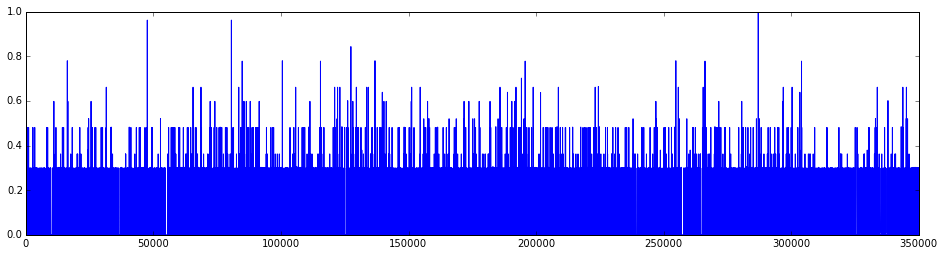

In [23]:
fig = plt.gcf()
fig.set_size_inches((16,4))
plt.plot(y_train[:,1])
plt.xlim([0,350000])

## Natural Scenes STA

In [40]:
sta = np.zeros_like(X_train[0], dtype='float32')
for idx, label in enumerate(y_train[:,0]):
    sta += label * X_train[idx].astype('float32')

<matplotlib.colorbar.Colorbar instance at 0x11a3ca170>

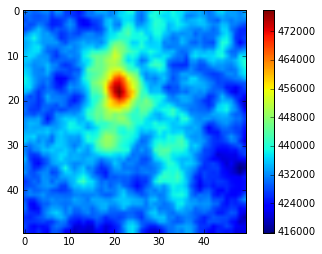

In [56]:
plt.imshow(sta[0,:,:])
plt.colorbar()

## Load Binary White Noise Data

In [5]:
data_dir = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Data 2015_10_07/whitenoise.h5'

In [6]:
X_train, y_train, X_test, y_test = loadData(data_dir)

(359762, 40, 50, 50)
(359762, 9)
(5957, 40, 50, 50)
(5957, 9)


In [7]:
X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped = createTrainValTest(X_train, y_train, X_test, y_test, 1, 100)

(0, 350000)

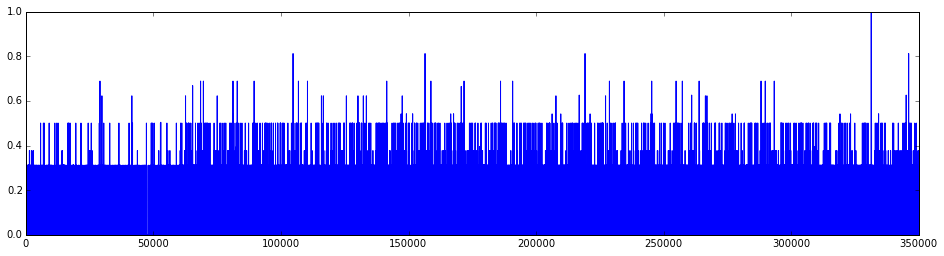

In [8]:
fig = plt.gcf()
fig.set_size_inches((16,4))
plt.plot(y_train[:,1])
plt.xlim([0,350000])

## White noise STA

In [34]:
cell = 0
sta_whitenoise = np.zeros_like(X_train[0], dtype='float32')
for idx, label in enumerate(y_train[:,cell]):
    sta_whitenoise += label * X_train[idx].astype('float32')

<matplotlib.colorbar.Colorbar instance at 0x119cfd200>

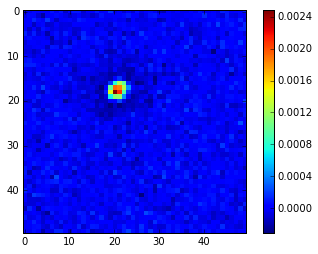

In [49]:
sta_whitenoise -= np.mean(sta_whitenoise)
sta_whitenoise /= np.var(sta_whitenoise)
max_arg = int(np.argmax(sta_whitenoise)/(50.*50.))
plt.imshow(sta_whitenoise[max_arg,:,:], interpolation='nearest')
plt.colorbar()

## Find nonlinearity

In [36]:
sta_whitenoise.shape

(40, 50, 50)

In [37]:
X_train.shape

(359762, 40, 50, 50)

In [38]:
#sta_whitenoise_flattened = sta_whitenoise.flatten()

In [54]:
y_predicted = []
for sample in X_train:
    predicted_response = np.sum(sta_whitenoise * sample)
    y_predicted.append(predicted_response)

In [40]:
# can't do an efficient dot product because of memory issues
#X_train_flattened = X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2]*X_train.shape[3]))
#X_train_flattened.shape

In [55]:
len(y_predicted)

359762

In [56]:
y_train.shape

(359762, 9)

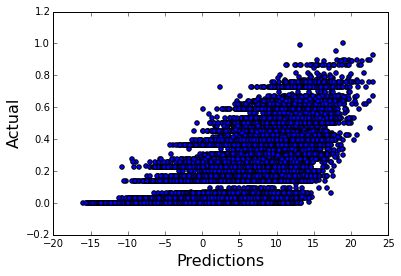

In [113]:
plt.scatter(y_predicted, y_train[:,cell])
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actual', fontsize=16)

In [114]:
def relu(x, threshold, gain):
    return np.where(x > threshold, (x-threshold)*gain, 0)

In [115]:
def objective_fn(x, y_pred, y_train):
    thresh = x[0]
    gain = x[1]
    return np.mean(np.abs(relu(y_pred, thresh, gain) - y_train))

In [116]:
from scipy.optimize import minimize

In [117]:
res = minimize(objective_fn, x0=(-0.5, 0.5), args=(np.array(y_predicted), y_train[:,cell]), method='Nelder-Mead')
res

  status: 0
    nfev: 148
 success: True
     fun: 0.030530784678954516
       x: array([ 4.79033249,  0.04950899])
 message: 'Optimization terminated successfully.'
     nit: 77

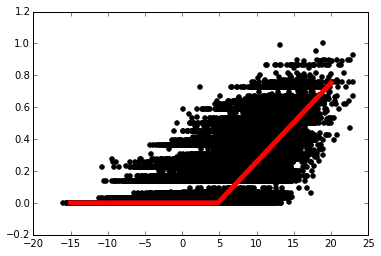

In [119]:
plt.scatter(y_predicted, y_train[:,cell], color='k')
plt.plot(np.linspace(-15,20,1000), relu(np.linspace(-15,20,1000),*res.x), 'r', linewidth=5)

In [120]:
LN_predictions_whitenoise = relu(np.array(y_predicted), *res.x)

## Also get predictions for natural scenes

In [138]:
data_dir_ns = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Data 2015_10_07/naturalscene.h5'
X_train_ns, y_train_ns, X_test_ns, y_test_ns = loadData(data_dir_ns)

(359762, 40, 50, 50)
(359762, 9)
(5957, 40, 50, 50)
(5957, 9)


In [139]:
y_predicted_ns = []
for sample in X_train_ns:
    predicted_response_ns = np.sum(sta_whitenoise * sample)
    y_predicted_ns.append(predicted_response_ns)

In [140]:
LN_predictions_naturalscenes = relu(np.array(y_predicted_ns), *res.x)

In [141]:
import pickle
pickle.dump(LN_predictions_whitenoise, open("LN_whitenoise_predictions.p", "wb"))
pickle.dump(LN_predictions_naturalscenes, open("LN_naturalscenes_predictions.p", "wb"))

## What does LN performance on white noise look like?

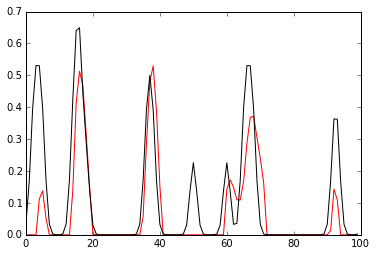

In [148]:
plt.plot(LN_predictions_whitenoise[:100], 'r')
plt.plot(y_train[:,0][:100], 'k')

## What does LN performance on natural scenes look like?

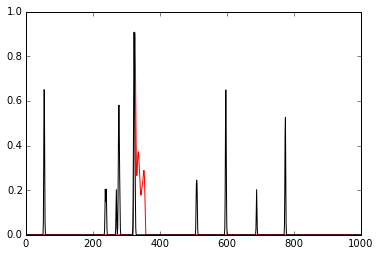

In [146]:
plt.plot(LN_predictions_naturalscenes[:1000], 'r')
plt.plot(y_train_ns[:,0][:1000], 'k')

## Correlation between labels and LN predictions

In [143]:
from scipy.stats import pearsonr

In [144]:
pearsonr(LN_predictions_naturalscenes, y_train_ns[:,0])

(0.15291147554424328, 0.0)

In [145]:
pearsonr(LN_predictions_whitenoise, y_train[:,0])

(0.68979312789648872, 0.0)